## Evaluating RTE energy consumption prediction model

Réseau de Transport d'Électricité ("Electricity Transmission Network"), usually known as RTE, is the electricity transmission system operator of France.

![title](images/logo_rte.png)

In this notebook, we will try to evaluate the RTE energy consumption prediction model

RTE is making it possible to consult real time electricity consumption in France using its platform at : https://www.rte-france.com/eco2mix/la-consommation-delectricite-en-france

![title](images/rte_tool.png)

By inspecting the element and watching the network we can easily find the API user to retrieve this data

![title](images/xmlFileScreenShot.png)

An example of an API call to retrive electricity consumption for 03/11/2022

https://eco2mix.rte-france.com/curves/eco2mixWeb?type=conso&dateDeb=03/11/2022&dateFin=03/11/2022&mode=NORM

## Collecting data

Having the API, we can collect the data by making as many requests as the number of days we are interested in

We can collect the electricity consumption data from the RTE API by executing the following code

In [6]:
from calendar import monthrange
import datetime
import requests

# Function to collect the data from the RTE API given a day : jj/mm/YYYY
def getDataOfTheDay(dayStr) :
    url = "https://eco2mix.rte-france.com/curves/eco2mixWeb?type=conso&dateDeb=" + dayStr + "&dateFin=" + dayStr + "&mode=NORM"
    headers = {
        "accept": "*/*",
        "accept-language": "fr,en-US;q=0.9,en;q=0.8,ar;q=0.7,fr-FR;q=0.6,ar-MA;q=0.5",
        "sec-ch-ua": "\"Google Chrome\";v=\"107\", \"Chromium\";v=\"107\", \"Not=A?Brand\";v=\"24\"",
        "sec-ch-ua-mobile": "?1",
        "sec-ch-ua-platform": "\"Android\"",
        "sec-fetch-dest": "empty",
        "sec-fetch-mode": "cors",
        "sec-fetch-site": "same-site",
        "Referer": "https://www.rte-france.com/",
        "Referrer-Policy": "strict-origin-when-cross-origin"
    }
    response = requests.request("POST", url, headers=headers)
    return response.text

# Function to write text to a file
def writeTextToFile(text, fileName) :
    f = open(fileName, "w+", encoding="utf-8")
    f.write(text)
    f.close()

# We will collect the data from January to October 2022
year = 2022
listOfMonths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
counter = 1
for month in listOfMonths :
    num_days = monthrange(year, month)[1]  # num_days = 28
    days = [datetime.date(year, month, day) for day in range(1, num_days + 1)]
    for thisDay in days:
        thisDayStr = thisDay.strftime("%d/%m/%Y")
        data = getDataOfTheDay(thisDayStr)
        fileName = "data/day" + "{:03d}".format(counter) + "_" + thisDay.strftime("%d-%m-%Y") + ".xml"
        writeTextToFile(data, fileName)
        counter += 1
print("Data is collected from RTE API and stored in the directory : data")

Data is collected from RTE API and stored in the directory : data


## Transforming the xml files to a single csv file

As we can notice, the data we collected is on xml format which doesn't help up as a lot

We will transform these files to a single csv file that centralize all the real and predicted consumption data

In [25]:
import xml.etree.ElementTree as ET
import csv
from os import listdir
from os.path import isfile, join

myPath = "data/"
onlyFiles = [f for f in listdir(myPath) if isfile(join(myPath, f))]

allData = []
allData.append(["consommation", "previsionJ"])
for thisXmlFile in onlyFiles :
    tree = ET.parse('data/'+thisXmlFile)
    root = tree.getroot()
    consommation = root[7][0]
    previsionJ = root[7][2]
    # Every file has 96 entries
    for i in range(96):
        data = [consommation[i].text, previsionJ[i].text]
        allData.append(data)

with open('electricityConsumptionRealAndPrediction.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for thisLine in allData :
        writer.writerow(thisLine)
print("All the data is now stored in the file electricityConsumptionRealAndPrediction.csv")

All the data is now stored in the file electricityConsumptionRealAndPrediction.csv


## Evaluating the predicition model

Now that we have the data centralized in a csv file we can use pandas to load this data and sklearn to have some metrics about it.

In [26]:
import pandas as pd
df = pd.read_csv("electricityConsumptionRealAndPrediction.csv", sep=",")

In [27]:
df

,consommation,previsionJ
0,54578,54200
1,54331,53750
2,54083,53300
3,53126,52400
4,52169,51500
...,...,...
29179,41265,40300
29180,41090,41200
29181,41203,40850
29182,40735,40500


In [28]:
dfLastDay = pd.DataFrame.tail(df, n=96)


In [29]:
dfLastDay

,consommation,previsionJ
29088,39235,39400
29089,38939,38750
29090,37547,38100
29091,36055,37100
29092,35711,36100
...,...,...
29179,41265,40300
29180,41090,41200
29181,41203,40850
29182,40735,40500


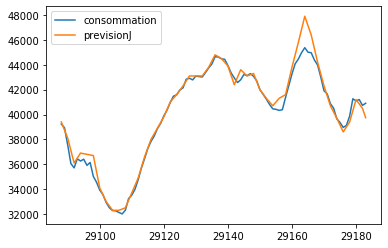

In [30]:
import matplotlib.pyplot as plt
dfLastDay.plot()
plt.show()


We can notice that the predicted values are not always the same as the real electricity consumption values

In order to evaluate the RTE prediction model, we are going to use metrics called : **MAE (Mean absolute error), MAPE (Mean absolute percentage error)**

In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. MAE is calculated as :

![title](images/mae.png)

The **mean absolute percentage error (MAPE)**, also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics. It usually expresses the accuracy as a ratio defined by the formula:

![title](images/mape2.png)

We can find this metric already implemnted in **sklearn.metrics**

### Computing the mean absolute error

In [31]:
from sklearn.metrics import mean_absolute_error

In [32]:
y_real = df["consommation"]
y_predict = df["previsionJ"]
mae = mean_absolute_error(y_real, y_predict)

In [33]:
mae

630.8755139802631

### Computing the mean absolute percentage error

In [34]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_real, y_predict)

In [35]:
mape

0.012110706069023864

As we can see, the MAPE is **0.01211** which is very good.

That means the model make an error of 1.211 % on its predictions which is very good.